In [143]:
%%HTML
<style>
  @import url('https://fonts.googleapis.com/css2?family=JetBrains+Mono&display=swap');

  body {
    font-family: 'JetBrains Mono', -apple-system, BlinkMacSystemFont, 'Segoe WPC', 'Segoe UI', system-ui, 'Ubuntu', 'Droid Sans', sans-serif;
    line-height: 1.67;
  }
</style>

In [144]:
# Import modules for HTML display in the notebook and enable inline mode for Matplotlib
from IPython.display import display, HTML, Math, Latex
from IPython.core.magic import register_cell_magic
  
%matplotlib inline

# Import common libraries for data manipulation, optimization, and control
import pandas as pd  # type: ignore
import cvxpy as cp  # type: ignore
from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import matplotlib as mpl  # type: ignore
from matplotlib.patches import FancyArrowPatch # type: ignore
from scipy.integrate import quad # type: ignore
import importlib
import itertools
import csv
import concurrent.futures
from scipy.spatial import ConvexHull
import os, math, sys
import json
from scipy.interpolate import interp1d
import numpy as np
import json
from typing import Dict, List, Any, Optional, Literal


from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

base_path = os.path.abspath("..")  # pasta acima do notebook/script

dirs_to_add = ["Utils", "Optimization Problems", "DisturbedSaturatedPETC"]
for d in dirs_to_add:
    path = os.path.join(base_path, d)
    if path not in sys.path:
        sys.path.append(path)
        
import Tex as tex
import Graphs as gph
import Signal as sgn
import Numeric as nm
import DynamicSystem as ds
import DisturbedSaturatedPETC as DSPETC

importlib.reload(tex)
importlib.reload(gph)
importlib.reload(sgn)
importlib.reload(nm)
importlib.reload(ds)
importlib.reload(DSPETC)

# Attempt to configure LaTeX for text rendering, otherwise use default Matplotlib fonts
gph.use_latex()

# Set the resolution of figures generated by Matplotlib
mpl.rcParams['figure.dpi'] = 100

cfg = {
    'style': {'color': 'black'},
    'axis': {
        'title_pad': 10,
        'y_digits': 2,
        'x_digits': 2,
        'x_label_fontsize': 16,
        'y_label_fontsize': 16,
        'tick_fontsize': 16,
    },
}

@register_cell_magic
def skip(line, cell):
  return

LaTeX has been enabled for text rendering.


### Definição da Planta

In [145]:
experiment_config_filename = 'experiment-1'

with open(f"experiment_configs/{experiment_config_filename}.json", encoding='utf-8') as f:
  config = json.load(f)

sim_duration = config['simulation_duration']
sim_step = config.get("simulation_step", 1e-4)
timepts = np.arange(0, sim_duration + sim_step, sim_step)

plant = ds.StateSpace(data=config["plant"])
# for matrix in ["A", "B", "E"]:
#   plant.display_matrix(matrix)

### Simulação da Planta em Malha Aberta

In [146]:
ncs = ds.NetworkedControlSystem()
ncs.add_system(plant, 'plant')

x0 = np.array([[1.0], [-1.0]], dtype=np.float32)
ncs.get_system('plant').set_initial_state(x0)

ncs.setup_clock(duration=20.0, dt=1e-4)
ncs.reset_clock()

while ncs.advance_clock():
  inputs = {'plant': {'u1': 0}}
  ncs.update_systems(inputs)

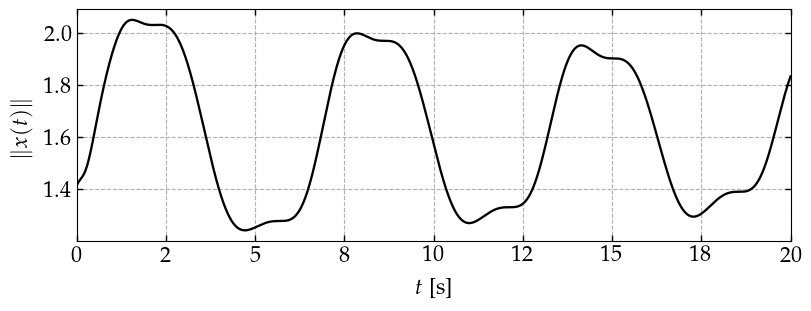

In [147]:
# Plotagem dos resultados
fig = plt.figure(figsize=(8, 3), layout='constrained')
axs = fig.subplot_mosaic([["x"]])

y = ncs.output_history['plant']  # shape (ny, n_steps)
t = ncs.time_history

# Calcula norma ao longo das saídas
x_norm = np.linalg.norm(y, axis=0)  # shape (n_steps,)

# Formata para plot
xnorm_f, xnorm_ul, xnorm_dp = nm.format_magnitudes(x_norm,  n_divs=5)
t_f, t_ul, t_dp = nm.format_magnitudes(t, 's', use_prefixes=True, n_divs=5)
axis_limits = {'x_min': 0., 'x_max': t_f[-1]}

gph.plot(
    axs['x'], t_f, x_norm,
    xlabel='$t$' + t_ul,
    ylabel=r'$\|x(t)\|$',
    plot_cfg={**cfg,
              'axis': {**cfg['axis'],
                       'x_digits': t_dp,
                       'y_digits': xnorm_dp},
              'limits': axis_limits,
              }
)

### Projeto do Controlador e do ETM

In [148]:
def get_C(rho_values):
  return np.array([[1.0, 0.0]], dtype=np.float32)


plant_data = {
    'nx': plant.nx,
    'nu': plant.nu,
    'nρ': plant.nρ,
    'nw': plant.nw,
    'ρ_bounds': [(-0.5, 0.5)],
    'u_bar': [.5],
    'matrices_func': lambda ρi: plant.matrices_func(ρi),
    'get_C': get_C
}

h, υ, ε_γ, δ, λ = 1e-3, 1e-1, 1e-1, 10, 1e-1
θ = (1. / λ) * (np.exp(λ * h) - 1) + 1

# --- Parâmetros de projeto ---
design_params = {'h': h, 'υ': υ, 'δ': δ, 'ε_γ': ε_γ, 'λ': λ, 'θ': θ}

# --- Executar o solver ---
results = DSPETC.DETM(plant_data, design_params)

Ξ = Ψ = K = L1 = P = γ = β = None
Θ, λ = None, None
optimal_value = None
δinv = 1e-1

if results is not None:
  Ξ, Ψ = results['etm']['Ξ'], results['etm']['Ψ']
  θ, λ = results['etm']['θ'], results['etm']['λ']
  K, L1, L2 = results['controller']['K'], results['controller']['L1'], \
      results['controller']['L2']
  P, S2 = results['lyapunov']
  γ, β = results['bounds']
  optimal_value = results['optimal_value']

  # print(f'β = {β:.3e}')
  # print(f'x.T P x <= {1./β:.3e}')
  print(f'θ = {θ:.3e}')
  print(f'λ = {λ:.3e}')
  print(f'γ = {γ:.3e}')
  print(f'Induced gain = {(np.sqrt(1. / γ)):.3e}')

  display(Math(rf'\Xi = {tex.mat2tex(Ξ)}'))
  display(Math(rf'\Psi = {tex.mat2tex(Ψ)}'))

  display(Math(rf'P = {tex.mat2tex(P)}'))

  for i in nm.binary_set(plant.nρ):
    display(Math(rf'K_{{{i}}} = {tex.mat2tex(K[i])}'))
    display(Math(rf'L_{{{i}}} = {tex.mat2tex(L1[i])}'))
else:
  print('Problema não é factível!')

θ = 1.001e+00
λ = 1.000e-01
γ = 1.000e-01
Induced gain = 3.162e+00


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Simulação do Sistema em Malha Fechada

In [159]:
importlib.reload(ds)

sampler = ds.Sampler(Ts=h)

In [ ]:
x0 = np.array([[1.0], [-1.0]], dtype=np.float32)
ncs.get_system('plant').set_initial_state(x0)

ncs.setup_clock(duration=1.0, dt=1e-4)
ncs.reset_clock()
sampler.reset()

while ncs.advance_clock():
  inputs = {'plant': {'u1': 0}}
  if sampler.check(ncs.t):
    print(ncs.t)
  ncs.update_systems(inputs)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()